# Series de tiempo cierre acciones con Arquitecturas RNN

En este notebook, se crean diferentes arquitectura de redes neuronales recurrentes (RNN) para evaluar cuál es la que mejor predice los movimientos del precio de cierre de las acciones. Los tipos de arquitectura RNN que serán implementadas LSTM y Encoders-Decoders, con las cuales se crean difentes modelos donde varia el número de neuronas de la capa LSTM y el lookback. Al final se seleccionan los modelos LSTM y Encoders-Decoders de menor pérdida para realizar las predicciones y compararlas con el precio de cierre original.

## Contenido

#### 1. Importación de librerías y cargue del dataset
#### 2. Definión funciones de creación de dataset y gráficos de los modelos
#### 3. LSTM
#### 4. Encoder-Decoder
#### 5. Encoder-Decoder version 2

## 1. Importación de librerías y cargue del dataset

A continuación, se cargan las librerías necesarias para completar esta tarea:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Sequential
%matplotlib inline

Using TensorFlow backend.


Se lee el archivo de excel que contiene la información del dataset y se convierte la columna fecha en el id de cada final.

In [2]:
dataset = pd.read_excel('./data/Dataset.xls')
dataset.set_index('fecha',inplace=True)
dataset.head()

,Cantidad,Volumen,BCOLOMBIA,Precio Mayor,Precio Medio,Precio Menor,Variacion,Variacion Absoluta,COLCAP,BOGOTA,...,upper_band,lower_band,ema,momentum,log_momentum,Fourier3,Fourier6,Fourier9,Fourier100,ARIMA
fecha,,,,,,,,,,,,,,,,,,,,,
2008-02-14,486958,7207593760,14720,14860,14801.2637,14720,0.14,20,928.67,29340,...,15726.977202,13393.022798,14696.852167,14719,9.596894,(23077.7896372-2047.39795493j),(23674.5437646-650.00805727j),(23945.950803-130.487624855j),(14657.7161987-17.6998958368j),14720.0
2008-02-15,177200,2612417120,14800,14900,14742.7603,14600,0.54,80,929.63,29400,...,15720.543495,13418.504124,14765.617389,14799,9.602315,(23037.1586527-2046.75954045j),(23584.8975715-648.262236787j),(23821.3641891-129.870353806j),(14978.1025656-27.1178367254j),14800.0
2008-02-18,41671,619473620,14980,14980,14865.8208,14800,1.22,180,944.25,29360,...,15510.878696,13711.978447,14908.539130,14979,9.614404,(22996.5552587-2046.02572901j),(23495.2077147-646.395558862j),(23696.6789755-129.19860656j),(15256.4954598-35.1374565661j),14980.0
2008-02-20,153372,2285441560,15000,15100,14901.2959,14740,-1.06,-160,941.38,29200,...,15452.079916,13957.443893,14969.513043,14999,9.615739,(22915.4357998-2044.27205648j),(23315.7211407-642.301045191j),(23447.0773391-127.692833309j),(15646.3056008-45.4210457344j),15000.0
2008-02-21,535243,8086448540,15200,15200,15107.9949,15000,1.33,200,944.38,29120,...,15433.445575,14128.459187,15123.171014,15199,9.628985,(22874.9220125-2043.25227713j),(23225.9365058-640.073972798j),(23322.1932437-126.859438924j),(15745.9082169-47.1547456557j),15200.0


Los componentes de la transformada de Fourier se convierten al formato de número complejo, debido a que al leerlos del archivo quedan como texto.

In [4]:
dataset['Fourier3'] = np.asarray(dataset['Fourier3'].tolist()).astype('complex')
dataset['Fourier6'] = np.asarray(dataset['Fourier6'].tolist()).astype('complex')
dataset['Fourier9'] = np.asarray(dataset['Fourier9'].tolist()).astype('complex')
dataset['Fourier100'] = np.asarray(dataset['Fourier100'].tolist()).astype('complex')

In [5]:
dataset.isnull().sum()

Cantidad              0
Volumen               0
BCOLOMBIA             0
Precio Mayor          0
Precio Medio          0
Precio Menor          0
Variacion             0
Variacion Absoluta    0
COLCAP                0
BOGOTA                0
OCCIDENTE             1
POPULAR               0
BBVACOL               0
BVC                   0
PROTECCION            0
ma7                   0
ma21                  0
26ema                 0
12ema                 0
MACD                  0
20sd                  0
upper_band            0
lower_band            0
ema                   0
momentum              0
log_momentum          0
Fourier3              0
Fourier6              0
Fourier9              0
Fourier100            0
ARIMA                 0
dtype: int64

In [6]:
dataset.fillna(0,inplace=True)

In [7]:
dataset.isnull().sum()

Cantidad              0
Volumen               0
BCOLOMBIA             0
Precio Mayor          0
Precio Medio          0
Precio Menor          0
Variacion             0
Variacion Absoluta    0
COLCAP                0
BOGOTA                0
OCCIDENTE             0
POPULAR               0
BBVACOL               0
BVC                   0
PROTECCION            0
ma7                   0
ma21                  0
26ema                 0
12ema                 0
MACD                  0
20sd                  0
upper_band            0
lower_band            0
ema                   0
momentum              0
log_momentum          0
Fourier3              0
Fourier6              0
Fourier9              0
Fourier100            0
ARIMA                 0
dtype: int64

## 2. Definión funciones de creación de dataset y gráficos de los modelos

Función para construir el dataset con múltiples características para train y test de acuerdo al lookback, time_ahead y caractetística a predecir.

In [8]:
def create_dataset_nfeatures(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1, index_feature_pred = None):
    dataX, dataY = [], []
    tem = n_steps_in + n_steps_out - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        startx = i*overlap
        endx = startx + n_steps_in
        starty = endx
        endy = endx + n_steps_out
        a = dataset[startx:endx, :]
        dataX.append(a)
        dataY.append(dataset[starty:endy,index_feature_pred])
    return np.array(dataX), np.array(dataY)

Función que grafica la pérdida mse de diferentes modelos.

In [9]:
def plot_metrics_model(mse, combinations, title):
    plt.figure(figsize=(20,8))
    plt.plot(mse, lw=4, alpha=.5, label="MSE models")
    plt.grid();
    plt.xlabel("Number of steps in")
    plt.ylabel("MSE")
    plt.title(title)    
    plt.xticks(np.arange(len(combinations)), combinations, rotation=90)
    plt.legend();
    plt.show()    

Función que grafica las predicciones de un modelo con la serie original.

In [10]:
def plot_predictions_model(x_lab1, Original_serie, x_lab2, trainPredict, x_lab3, testPredict, title):
    plt.plot(x_lab1,Original_serie, alpha=1, label='Original series');
    plt.plot(x_lab2,trainPredict,alpha=0.6, label='train prediction');
    plt.plot(x_lab3,testPredict, alpha=0.6, label='test prediction');
    plt.title(title);
    plt.legend();
    plt.show()  

Se crean y normalizan los datos de train y test del dataset.

In [11]:
data = dataset.values
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
trainN.shape,testN.shape

/opt/miniconda/lib/python2.7/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/opt/miniconda/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype complex128 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((1834, 31), (904, 31))

En la siguiente celda, se crean varios datasets de train y test donde para diferentes lookback. Se define time_ahead igual a 1 para predecir un solo movimiento y se selecciona como caractetística a predecir el precio de cierre de acciones de Bancolombia.

In [12]:
time_ahead=1

X_train=[]
y_train=[]
X_test=[]
y_test=[]
for i in range (10):
    X_trainTemp, y_trainTemp = create_dataset_nfeatures(trainN, time_ahead,i+1,index_feature_pred=2)
    X_testTemp, y_testTemp = create_dataset_nfeatures(testN, time_ahead,i+1,index_feature_pred=2)
    X_train.append(X_trainTemp),y_train.append(y_trainTemp),X_test.append(X_testTemp), y_test.append(y_testTemp)

In [13]:
len(X_train),X_train[0].shape,len(y_train),y_train[0].shape

(10, (1833, 1, 31), 10, (1833, 1))

Se definen las listas para crear diferentes tipos de modelos, donde se combinarán diferentes dimesiones de la capa LSTM y lookbacks.

In [14]:
ltsm_dim_set = [64,128,196,256]
look_back_set = [1,2,3,4,5,6,7,8,9,10]

## 3. LSTM

Función para crear, entrenar y calcular pérdida mse de modelos de arquitectura LTSM.

In [15]:
def LSTM_model(ltsm_dim, X_train, y_train, X_test, y_test, look_back):
    X_train=X_train[look_back-1]
    y_train=y_train[look_back-1]
    X_test=X_test[look_back-1]
    y_test=y_test[look_back-1]
    
    model = Sequential()    
    model.add(LSTM(ltsm_dim, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')
    
    print "Entrenado modelo LSTM con look_back de", look_back, "y neuronas", ltsm_dim
    model.fit(X_train, y_train.flatten(),epochs=20, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    return model, mse

Se crean los modelos LSTM con diferentes número de neuronas de la capa LSTM y lookback.

In [19]:
LSTM_models=[]
LSTM_mse=[]
LSTM_combinations = []
for ltsm_dim, look_back in itertools.product(ltsm_dim_set, look_back_set):
    model, mse = LSTM_model(ltsm_dim, X_train, y_train, X_test, y_test,look_back=look_back)
    LSTM_models.append(model), LSTM_mse.append(mse)
    LSTM_combinations.append('lstm '+str(ltsm_dim)+' - look_back '+str(look_back))

Entrenado modelo LSTM con look_back de 1 y neuronas 64
Epoch 1/20
1833/1833 [==============================] - 4s 2ms/step - loss: 0.0516
Epoch 2/20
1833/1833 [==============================] - 1s 370us/step - loss: 0.0022
Epoch 3/20
1833/1833 [==============================] - 1s 365us/step - loss: 0.0016
Epoch 4/20
1833/1833 [==============================] - 1s 352us/step - loss: 0.0013
Epoch 5/20
1833/1833 [==============================] - 1s 315us/step - loss: 0.0011
Epoch 6/20
1833/1833 [==============================] - 1s 363us/step - loss: 9.0011e-04
Epoch 7/20
1833/1833 [==============================] - 1s 351us/step - loss: 7.6140e-04
Epoch 8/20
1833/1833 [==============================] - 1s 361us/step - loss: 6.7670e-04
Epoch 9/20
1833/1833 [==============================] - 1s 322us/step - loss: 5.8775e-04
Epoch 10/20
1833/1833 [==============================] - 1s 324us/step - loss: 5.1912e-04
Epoch 11/20
1833/1833 [==============================] - 1s 355us/step - los

Epoch 1/20
1824/1824 [==============================] - 7s 4ms/step - loss: 0.0733
Epoch 2/20
1824/1824 [==============================] - 3s 1ms/step - loss: 0.0017
Epoch 3/20
1824/1824 [==============================] - 3s 1ms/step - loss: 0.0012
Epoch 4/20
1824/1824 [==============================] - 3s 1ms/step - loss: 0.0010
Epoch 5/20
1824/1824 [==============================] - 3s 1ms/step - loss: 8.9792e-04
Epoch 6/20
1824/1824 [==============================] - 3s 1ms/step - loss: 8.1011e-04
Epoch 7/20
1824/1824 [==============================] - 3s 1ms/step - loss: 7.4490e-04
Epoch 8/20
1824/1824 [==============================] - 3s 1ms/step - loss: 6.9641e-04
Epoch 9/20
1824/1824 [==============================] - 3s 1ms/step - loss: 6.5920e-04
Epoch 10/20
1824/1824 [==============================] - 3s 1ms/step - loss: 6.1869e-04
Epoch 11/20
1824/1824 [==============================] - 3s 1ms/step - loss: 5.7558e-04
Epoch 12/20
1824/1824 [==============================] - 

1825/1825 [==============================] - 9s 5ms/step - loss: 0.0247
Epoch 2/20
1825/1825 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 3/20
1825/1825 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 4/20
1825/1825 [==============================] - 3s 2ms/step - loss: 7.8492e-04
Epoch 5/20
1825/1825 [==============================] - 3s 2ms/step - loss: 6.7376e-04
Epoch 6/20
1825/1825 [==============================] - 3s 2ms/step - loss: 5.7461e-04
Epoch 7/20
1825/1825 [==============================] - 3s 2ms/step - loss: 5.3988e-04
Epoch 8/20
1825/1825 [==============================] - 3s 2ms/step - loss: 4.9332e-04
Epoch 9/20
1825/1825 [==============================] - 3s 2ms/step - loss: 4.7547e-04
Epoch 10/20
1825/1825 [==============================] - 3s 2ms/step - loss: 4.3720e-04
Epoch 11/20
1825/1825 [==============================] - 3s 2ms/step - loss: 4.5954e-04
Epoch 12/20
1825/1825 [==============================] - 3s 2ms/

1826/1826 [==============================] - 12s 7ms/step - loss: 0.0335
Epoch 2/20
1826/1826 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 3/20
1826/1826 [==============================] - 4s 2ms/step - loss: 8.4133e-04
Epoch 4/20
1826/1826 [==============================] - 4s 2ms/step - loss: 6.9152e-04
Epoch 5/20
1826/1826 [==============================] - 4s 2ms/step - loss: 5.6287e-04
Epoch 6/20
1826/1826 [==============================] - 4s 2ms/step - loss: 5.1839e-04
Epoch 7/20
1826/1826 [==============================] - 4s 2ms/step - loss: 4.9121e-04
Epoch 8/20
1826/1826 [==============================] - 4s 2ms/step - loss: 4.6157e-04
Epoch 9/20
1826/1826 [==============================] - 4s 2ms/step - loss: 4.0932e-04
Epoch 10/20
1826/1826 [==============================] - 4s 2ms/step - loss: 3.8465e-04
Epoch 11/20
1826/1826 [==============================] - 4s 2ms/step - loss: 3.9123e-04
Epoch 12/20
1826/1826 [==============================] - 4s

1827/1827 [==============================] - 8s 4ms/step - loss: 0.0473
Epoch 2/20
1827/1827 [==============================] - 3s 1ms/step - loss: 0.0015
Epoch 3/20
1827/1827 [==============================] - 3s 1ms/step - loss: 0.0011
Epoch 4/20
1827/1827 [==============================] - 3s 1ms/step - loss: 8.9462e-04
Epoch 5/20
1827/1827 [==============================] - 3s 1ms/step - loss: 7.9221e-04
Epoch 6/20
1827/1827 [==============================] - 3s 1ms/step - loss: 7.0247e-04
Epoch 7/20
1827/1827 [==============================] - 3s 1ms/step - loss: 6.3325e-04
Epoch 8/20
1827/1827 [==============================] - 3s 2ms/step - loss: 5.8771e-04
Epoch 9/20
1827/1827 [==============================] - 3s 2ms/step - loss: 5.3470e-04
Epoch 10/20
1827/1827 [==============================] - 3s 2ms/step - loss: 5.9634e-04
Epoch 11/20
1827/1827 [==============================] - 3s 2ms/step - loss: 4.5602e-04
Epoch 12/20
1827/1827 [==============================] - 3s 2ms/

Se grafica la pérdida mse de los modelos LSTM.

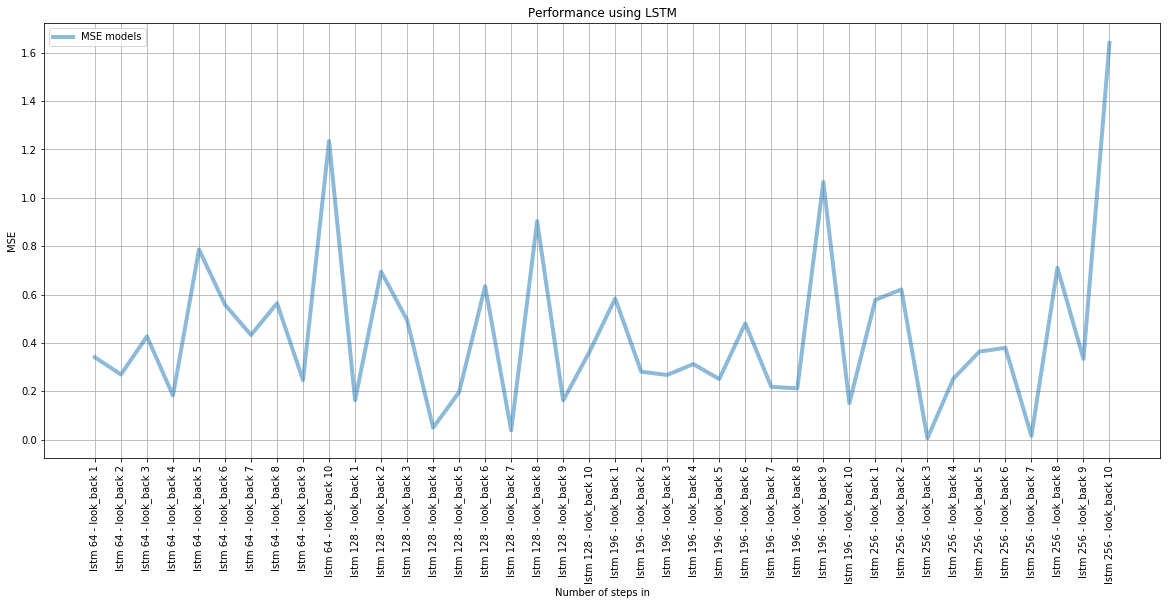

In [31]:
plot_metrics_model(LSTM_mse,LSTM_combinations, "Performance using LSTM")

Se muestra la pérdida mse de los modelos LSTM.

In [35]:
columns = ['model', 'mse']
df_models_lstm = pd.DataFrame(columns=columns)
df_models_lstm['model'] = LSTM_combinations
df_models_lstm['mse'] = LSTM_mse
df_models_lstm

,model,mse
0,lstm 64 - look_back 1,0.340879
1,lstm 64 - look_back 2,0.269648
2,lstm 64 - look_back 3,0.426860
3,lstm 64 - look_back 4,0.182703
4,lstm 64 - look_back 5,0.786426
5,lstm 64 - look_back 6,0.558245
6,lstm 64 - look_back 7,0.432819
7,lstm 64 - look_back 8,0.564225
8,lstm 64 - look_back 9,0.246021
9,lstm 64 - look_back 10,1.235327


Elegimos el modelo LSTM de menor pérdida mse.

In [159]:
index_model_min_mse = df_models_lstm[df_models_lstm.mse == df_models_lstm.mse.min()].index[0]
look_back = df_models_lstm.loc[index_model_min_mse,'model']
look_back = int(look_back[look_back.rfind(" ")+1:])
print index_model_min_mse, look_back
df_models_lstm[df_models_lstm.mse == df_models_lstm.mse.min()]

32 3


,model,mse
32,lstm 256 - look_back 3,0.005818


In [161]:
X_train[look_back-1].shape

(1831, 3, 31)

Realizamos las predicciones con el modelo LSTM seleccionado.

In [81]:
model_lstm = LSTM_models[index_model_min_mse]
model_lstm.summary()
trainPredict = model_lstm.predict(X_train[look_back-1])
testPredict = model_lstm.predict(X_test[look_back-1])
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 256)               294912    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 257       
Total params: 295,169
Trainable params: 295,169
Non-trainable params: 0
_________________________________________________________________


((1831, 1), (901, 1))

In [82]:
Original_serie = scaler.fit_transform(data[:,2].reshape(-1, 1))
Original_serie.shape

(2738, 1)

In [84]:
x_lab1=[]
for i in range(Original_serie.shape[0]):
    x_lab1.append(i)
x_lab2=[]
for i in range(trainPredict.shape[0]):
    x_lab2.append(i)
x_lab3=[]
for i in range(trainPredict.shape[0]+7,Original_serie.shape[0]+1):
    x_lab3.append(i)
    
len(x_lab1), Original_serie.shape[0],len(x_lab2), trainPredict.shape[0],len(x_lab3), testPredict.shape[0]

(2738, 2738, 1831, 1831, 901, 901)

Se grafican las predicciones del modelo LSTM con los datos de cierre de precio originales.

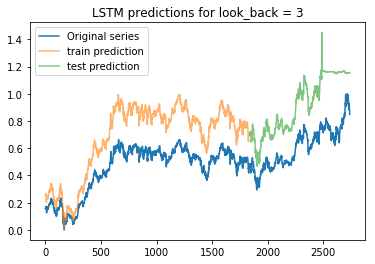

In [85]:
plot_predictions_model(x_lab1, 
                       Original_serie, 
                       x_lab2, 
                       trainPredict, 
                       x_lab3, 
                       testPredict, 
                       "LSTM predictions for look_back = 3")

Se exporta el modelo LSTM entrenado.

In [196]:
model_dir = './models/'
tf.gfile.MakeDirs(model_dir)
model_name = df_models_lstm.loc[index_model_min_mse,'model']
model_lstm.save(model_dir+model_name+".model")

## 4. Encoder-Decoder

Función para crear, entrenar y calcular pérdida mse de modelos de arquitectura Encoder-Decoder.

In [14]:
def EncoDeco_model(ltsm_dim, X_train, y_train, X_test, y_test, look_back, time_ahead):
    X_train=X_train[look_back-1]
    y_train=y_train[look_back-1]
    X_test=X_test[look_back-1]
    y_test=y_test[look_back-1]
    
    model = Sequential()    
    model.add(LSTM(ltsm_dim,activation='relu',input_shape=(look_back,X_train.shape[2])))
    model.add(RepeatVector(time_ahead))
    model.add(LSTM(ltsm_dim/4, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam',loss='mse')
    
    print "Entrenado modelo Encoder-Decoder con look_back de", look_back, "y neuronas", ltsm_dim
    model.fit(X_train, np.reshape(y_train,(y_train.shape[0],time_ahead,1)),epochs=20, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(np.reshape(y_test,(y_test.shape[0]*time_ahead)),np.reshape(pred,(pred.shape[0]*time_ahead)))
    return model, mse

Se crean los modelos Encoder-Decoder con diferentes número de neuronas de las capas LSTM y lookback.

In [15]:
encodeco_models=[]
encodeco_mse=[]
encodeco_combinations = []
for ltsm_dim, look_back in itertools.product(ltsm_dim_set, look_back_set):
    model, mse = EncoDeco_model(ltsm_dim, X_train, y_train, X_test, y_test,look_back=look_back, time_ahead=time_ahead)
    encodeco_models.append(model), encodeco_mse.append(mse)
    encodeco_combinations.append('encodeco '+str(ltsm_dim)+' - look_back '+str(look_back))

Entrenado modelo Encoder-Decoder con look_back de 1 y neuronas 64
Epoch 1/20
1833/1833 [==============================] - 5s 3ms/step - loss: 0.1934
Epoch 2/20
1833/1833 [==============================] - 1s 491us/step - loss: 0.0031
Epoch 3/20
1833/1833 [==============================] - 1s 447us/step - loss: 0.0019
Epoch 4/20
1833/1833 [==============================] - 1s 489us/step - loss: 0.0012
Epoch 5/20
1833/1833 [==============================] - 1s 465us/step - loss: 8.3006e-04
Epoch 6/20
1833/1833 [==============================] - 1s 497us/step - loss: 6.3695e-04
Epoch 7/20
1833/1833 [==============================] - 1s 465us/step - loss: 5.5157e-04
Epoch 8/20
1833/1833 [==============================] - 1s 557us/step - loss: 5.0375e-04
Epoch 9/20
1833/1833 [==============================] - 1s 544us/step - loss: 4.6431e-04
Epoch 10/20
1833/1833 [==============================] - 1s 477us/step - loss: 4.4689e-04
Epoch 11/20
1833/1833 [==============================] - 1s 5

1829/1829 [==============================] - 2s 1ms/step - loss: 4.0056e-04
Epoch 11/20
1829/1829 [==============================] - 2s 942us/step - loss: 4.2912e-04
Epoch 12/20
1829/1829 [==============================] - 2s 924us/step - loss: 3.9186e-04
Epoch 13/20
1829/1829 [==============================] - 2s 939us/step - loss: 4.0311e-04
Epoch 14/20
1829/1829 [==============================] - 2s 940us/step - loss: 3.8672e-04
Epoch 15/20
1829/1829 [==============================] - 2s 926us/step - loss: 4.3362e-04
Epoch 16/20
1829/1829 [==============================] - 2s 910us/step - loss: 3.9815e-04
Epoch 17/20
1829/1829 [==============================] - 2s 928us/step - loss: 3.5148e-04
Epoch 18/20
1829/1829 [==============================] - 2s 943us/step - loss: 4.3471e-04
Epoch 19/20
1829/1829 [==============================] - 2s 940us/step - loss: 3.7436e-04
Epoch 20/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.8544e-04
Entrenado modelo Encoder-D

1830/1830 [==============================] - 2s 1ms/step - loss: 4.4296e-04
Epoch 10/20
1830/1830 [==============================] - 2s 1ms/step - loss: 4.0462e-04
Epoch 11/20
1830/1830 [==============================] - 2s 985us/step - loss: 4.5575e-04
Epoch 12/20
1830/1830 [==============================] - 2s 999us/step - loss: 3.9591e-04
Epoch 13/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.8066e-04
Epoch 14/20
1830/1830 [==============================] - 2s 1ms/step - loss: 4.0428e-04
Epoch 15/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.4127e-04
Epoch 16/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.5883e-04
Epoch 17/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.5831e-04
Epoch 18/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.5922e-04
Epoch 19/20
1830/1830 [==============================] - 2s 1ms/step - loss: 4.0624e-04
Epoch 20/20
1830/1830 [=================

1831/1831 [==============================] - 2s 1ms/step - loss: 4.0898e-04
Epoch 9/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.9866e-04
Epoch 10/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.7914e-04
Epoch 11/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.8486e-04
Epoch 12/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.6160e-04
Epoch 13/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.5749e-04
Epoch 14/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.2324e-04
Epoch 15/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.1570e-04
Epoch 16/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.1732e-04
Epoch 17/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.3721e-04
Epoch 18/20
1831/1831 [==============================] - 2s 1ms/step - loss: 3.3783e-04
Epoch 19/20
1831/1831 [======================

1832/1832 [==============================] - 2s 1ms/step - loss: 4.0428e-04
Epoch 8/20
1832/1832 [==============================] - 2s 1ms/step - loss: 4.0258e-04
Epoch 9/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.6812e-04
Epoch 10/20
1832/1832 [==============================] - 2s 1ms/step - loss: 4.2940e-04
Epoch 11/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.4086e-04
Epoch 12/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.4340e-04
Epoch 13/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.5019e-04
Epoch 14/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.6676e-04
Epoch 15/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.3435e-04
Epoch 16/20
1832/1832 [==============================] - 2s 1ms/step - loss: 3.4874e-04
Epoch 17/20
1832/1832 [==============================] - 2s 1ms/step - loss: 4.0545e-04
Epoch 18/20
1832/1832 [=======================

/opt/miniconda/lib/python2.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242795). Check your callbacks.
  % delta_t_median)


1827/1827 [==============================] - 30s 16ms/step - loss: 0.0704
Epoch 2/20
1827/1827 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 3/20
1827/1827 [==============================] - 4s 2ms/step - loss: 7.8965e-04
Epoch 4/20
1827/1827 [==============================] - 4s 2ms/step - loss: 7.7600e-04
Epoch 5/20
1827/1827 [==============================] - 4s 2ms/step - loss: 7.1981e-04
Epoch 6/20
1827/1827 [==============================] - 4s 2ms/step - loss: 6.1059e-04
Epoch 7/20
1827/1827 [==============================] - 4s 2ms/step - loss: 5.8772e-04
Epoch 8/20
1827/1827 [==============================] - 4s 2ms/step - loss: 5.5289e-04
Epoch 9/20
1827/1827 [==============================] - 17s 9ms/step - loss: 5.7930e-04
Epoch 10/20
1827/1827 [==============================] - 6s 3ms/step - loss: 4.9750e-04
Epoch 11/20
1827/1827 [==============================] - 5s 3ms/step - loss: 4.6549e-04
Epoch 12/20
1827/1827 [==============================] - 

/opt/miniconda/lib/python2.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202549). Check your callbacks.
  % delta_t_median)


1825/1825 [==============================] - 21s 12ms/step - loss: 0.0464
Epoch 2/20
1825/1825 [==============================] - 5s 3ms/step - loss: 0.0013
Epoch 3/20
1825/1825 [==============================] - 4s 2ms/step - loss: 8.4513e-04
Epoch 4/20
1825/1825 [==============================] - 4s 2ms/step - loss: 8.1939e-04
Epoch 5/20
1825/1825 [==============================] - 4s 2ms/step - loss: 7.8134e-04
Epoch 6/20
1825/1825 [==============================] - 4s 2ms/step - loss: 7.6655e-04
Epoch 7/20
1825/1825 [==============================] - 21s 12ms/step - loss: 6.6497e-04
Epoch 8/20
1825/1825 [==============================] - 8s 4ms/step - loss: 5.7553e-04
Epoch 9/20
1825/1825 [==============================] - 6s 3ms/step - loss: 6.6346e-04
Epoch 10/20
1825/1825 [==============================] - 5s 3ms/step - loss: 4.9406e-04
Epoch 11/20
1825/1825 [==============================] - 5s 3ms/step - loss: 4.4309e-04
Epoch 12/20
1825/1825 [==============================] -

Se grafica la pérdida mse de los modelos Encoder-Decoder.

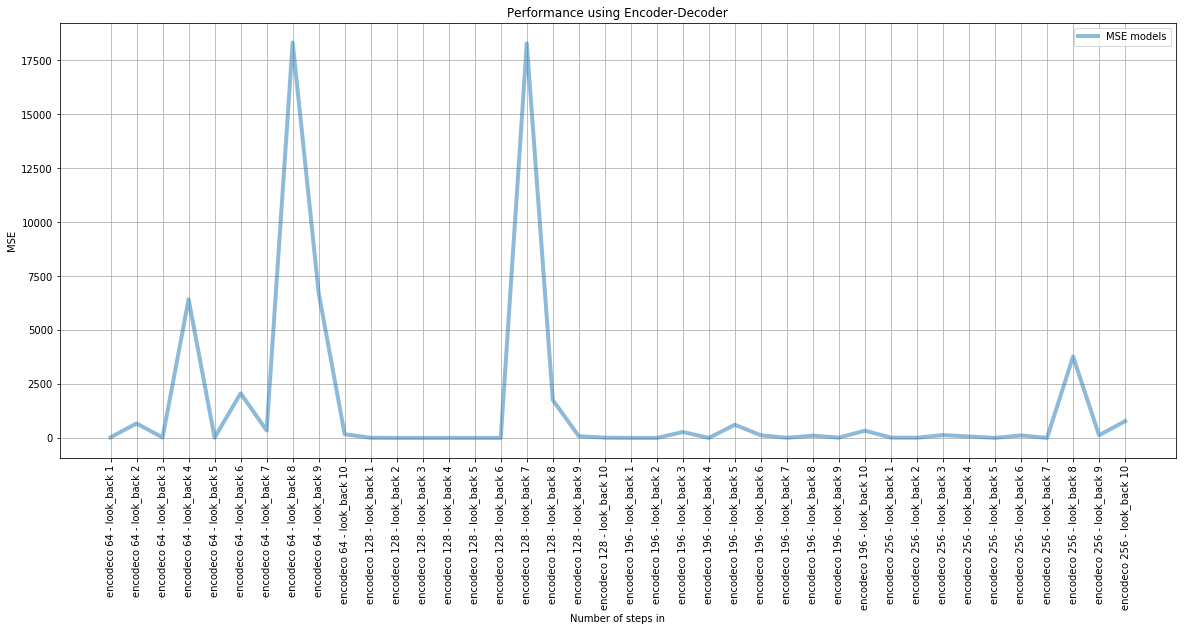

In [105]:
plot_metrics_model(encodeco_mse,encodeco_combinations, "Performance using Encoder-Decoder")

Se muestra la pérdida mse de los modelos Encoder-Decoder.

In [89]:
columns = ['model', 'mse']
df_models_encodeco = pd.DataFrame(columns=columns)
df_models_encodeco['model'] = encodeco_combinations
df_models_encodeco['mse'] = encodeco_mse
df_models_encodeco

,model,mse
0,encodeco 64 - look_back 1,26.720762
1,encodeco 64 - look_back 2,672.472125
2,encodeco 64 - look_back 3,18.643640
3,encodeco 64 - look_back 4,6426.377722
4,encodeco 64 - look_back 5,10.422022
5,encodeco 64 - look_back 6,2068.117890
6,encodeco 64 - look_back 7,343.630400
7,encodeco 64 - look_back 8,18328.290769
8,encodeco 64 - look_back 9,6725.815821
9,encodeco 64 - look_back 10,169.948012


Elegimos el modelo Encoder-Decoder de menor pérdida mse.

In [90]:
index_model_min_mse = df_models_encodeco[df_models_encodeco.mse == df_models_encodeco.mse.min()].index[0]
look_back = df_models_encodeco.loc[index_model_min_mse,'model']
look_back = int(look_back[look_back.rfind(" ")+1:])
print index_model_min_mse, look_back
df_models_encodeco[df_models_encodeco.mse == df_models_encodeco.mse.min()]

20 1


,model,mse
20,encodeco 196 - look_back 1,0.061668


Realizamos las predicciones con el modelo Encoder-Decoder seleccionado.

In [91]:
model_encodeco = encodeco_models[index_model_min_mse]
model_encodeco.summary()
trainPredict = model_encodeco.predict(X_train[look_back-1])
testPredict = model_encodeco.predict(X_test[look_back-1])
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 196)               178752    
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 1, 196)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1, 49)             48216     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 1, 1)              50        
Total params: 227,018
Trainable params: 227,018
Non-trainable params: 0
_________________________________________________________________


((1833, 1, 1), (903, 1, 1))

In [92]:
Original_serie = scaler.fit_transform(data[:,2].reshape(-1, 1))
Original_serie.shape

(2738, 1)

In [93]:
x_lab1=[]
for i in range(Original_serie.shape[0]):
    x_lab1.append(i)
x_lab2=[]
for i in range(trainPredict.shape[0]):
    x_lab2.append(i)
x_lab3=[]
for i in range(trainPredict.shape[0]+3,Original_serie.shape[0]+1):
    x_lab3.append(i)
    
len(x_lab1), Original_serie.shape[0],len(x_lab2), trainPredict.shape[0],len(x_lab3), testPredict.shape[0]

(2738, 2738, 1833, 1833, 903, 903)

Se grafican las predicciones del modelo Encoder-Decoder con los datos de cierre de precio originales.

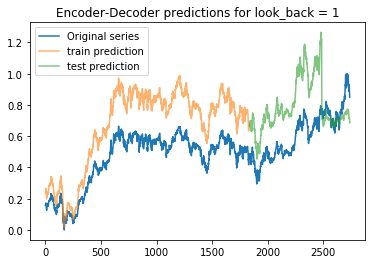

In [94]:
plot_predictions_model(x_lab1, 
                       Original_serie, 
                       x_lab2, 
                       np.reshape(trainPredict,(trainPredict.shape[0]*time_ahead)), 
                       x_lab3, 
                       np.reshape(testPredict,(testPredict.shape[0]*time_ahead)), 
                       "Encoder-Decoder predictions for look_back = 1")

Se exporta el modelo Encoder-Decoder entrenado.

In [95]:
model_dir = './models/'
tf.gfile.MakeDirs(model_dir)
model_name = df_models_encodeco.loc[index_model_min_mse,'model']
model_encodeco.save(model_dir+model_name+".model")

## 5. Encoder-Decoder version 2

Función para crear, entrenar y calcular pérdida mse de modelos de arquitectura Encoder-Decoder diferente al definido en el punto 5. En este caso, la segunda capa LSTM tiene la mitad de neuronas de las que tiene la primera capa LSTM.

In [16]:
def EncoDeco_model_2(ltsm_dim, X_train, y_train, X_test, y_test, look_back, time_ahead):
    X_train=X_train[look_back-1]
    y_train=y_train[look_back-1]
    X_test=X_test[look_back-1]
    y_test=y_test[look_back-1]
    
    model = Sequential()    
    model.add(LSTM(ltsm_dim,activation='relu',input_shape=(look_back,X_train.shape[2])))
    model.add(RepeatVector(time_ahead))
    model.add(LSTM(ltsm_dim/2, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam',loss='mse')
    
    print "Entrenado modelo Encoder-Decoder con look_back de", look_back, "y neuronas", ltsm_dim
    model.fit(X_train, np.reshape(y_train,(y_train.shape[0],time_ahead,1)),epochs=20, verbose=1)
    pred = model.predict(X_test)
    mse = mean_squared_error(np.reshape(y_test,(y_test.shape[0]*time_ahead)),np.reshape(pred,(pred.shape[0]*time_ahead)))
    return model, mse

Se crean los modelos Encoder-Decoder version 2 con diferentes número de neuronas de las capas LSTM y lookback.

In [18]:
encodeco_models_2=[]
encodeco_mse_2=[]
encodeco_combinations_2 = []
for ltsm_dim, look_back in itertools.product(ltsm_dim_set, look_back_set):
    model, mse = EncoDeco_model_2(ltsm_dim, X_train, y_train, X_test, y_test,look_back=look_back, time_ahead=time_ahead)
    encodeco_models_2.append(model), encodeco_mse_2.append(mse)
    encodeco_combinations_2.append('encodeco '+str(ltsm_dim)+' - look_back '+str(look_back))

Entrenado modelo Encoder-Decoder con look_back de 1 y neuronas 64
Epoch 1/20
1833/1833 [==============================] - 7s 4ms/step - loss: 0.1596
Epoch 2/20
1833/1833 [==============================] - 1s 610us/step - loss: 0.0023
Epoch 3/20
1833/1833 [==============================] - 1s 582us/step - loss: 0.0013
Epoch 4/20
1833/1833 [==============================] - 1s 609us/step - loss: 7.6439e-04
Epoch 5/20
1833/1833 [==============================] - 1s 602us/step - loss: 6.7148e-04
Epoch 6/20
1833/1833 [==============================] - 1s 582us/step - loss: 5.0580e-04
Epoch 7/20
1833/1833 [==============================] - 1s 526us/step - loss: 4.5966e-04
Epoch 8/20
1833/1833 [==============================] - 1s 573us/step - loss: 4.4067e-04
Epoch 9/20
1833/1833 [==============================] - 1s 617us/step - loss: 4.1822e-04
Epoch 10/20
1833/1833 [==============================] - 1s 560us/step - loss: 4.1822e-04
Epoch 11/20
1833/1833 [==============================] - 

1829/1829 [==============================] - 2s 1ms/step - loss: 4.5548e-04
Epoch 11/20
1829/1829 [==============================] - 2s 1ms/step - loss: 4.3306e-04
Epoch 12/20
1829/1829 [==============================] - 2s 1ms/step - loss: 4.1393e-04
Epoch 13/20
1829/1829 [==============================] - 2s 1ms/step - loss: 4.4013e-04
Epoch 14/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.9245e-04
Epoch 15/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.7148e-04
Epoch 16/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.6027e-04
Epoch 17/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.7862e-04
Epoch 18/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.5389e-04
Epoch 19/20
1829/1829 [==============================] - 2s 1ms/step - loss: 4.7753e-04
Epoch 20/20
1829/1829 [==============================] - 2s 1ms/step - loss: 3.5008e-04
Entrenado modelo Encoder-Decoder con look_ba

1825/1825 [==============================] - 4s 2ms/step - loss: 3.2732e-04
Entrenado modelo Encoder-Decoder con look_back de 10 y neuronas 64
Epoch 1/20
1824/1824 [==============================] - 13s 7ms/step - loss: 0.0638
Epoch 2/20
1824/1824 [==============================] - 4s 2ms/step - loss: 0.0017
Epoch 3/20
1824/1824 [==============================] - 4s 2ms/step - loss: 8.4476e-04
Epoch 4/20
1824/1824 [==============================] - 4s 2ms/step - loss: 7.2724e-04
Epoch 5/20
1824/1824 [==============================] - 4s 2ms/step - loss: 7.1432e-04
Epoch 6/20
1824/1824 [==============================] - 4s 2ms/step - loss: 6.0276e-04
Epoch 7/20
1824/1824 [==============================] - 4s 2ms/step - loss: 5.7447e-04
Epoch 8/20
1824/1824 [==============================] - 4s 2ms/step - loss: 5.9992e-04
Epoch 9/20
1824/1824 [==============================] - 4s 2ms/step - loss: 4.8909e-04
Epoch 10/20
1824/1824 [==============================] - 4s 2ms/step - loss: 4.49

1830/1830 [==============================] - 3s 1ms/step - loss: 5.0376e-04
Epoch 10/20
1830/1830 [==============================] - 3s 1ms/step - loss: 4.2204e-04
Epoch 11/20
1830/1830 [==============================] - 2s 1ms/step - loss: 4.2781e-04
Epoch 12/20
1830/1830 [==============================] - 2s 1ms/step - loss: 4.1210e-04
Epoch 13/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.8720e-04
Epoch 14/20
1830/1830 [==============================] - 2s 1ms/step - loss: 4.5486e-04
Epoch 15/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.6068e-04
Epoch 16/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.8017e-04
Epoch 17/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.6745e-04
Epoch 18/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.4390e-04
Epoch 19/20
1830/1830 [==============================] - 2s 1ms/step - loss: 3.7139e-04
Epoch 20/20
1830/1830 [=====================

1826/1826 [==============================] - 4s 2ms/step - loss: 3.4382e-04
Epoch 20/20
1826/1826 [==============================] - 4s 2ms/step - loss: 3.9990e-04
Entrenado modelo Encoder-Decoder con look_back de 9 y neuronas 128
Epoch 1/20
1825/1825 [==============================] - 16s 9ms/step - loss: 0.0797
Epoch 2/20
1825/1825 [==============================] - 4s 2ms/step - loss: 0.0018
Epoch 3/20
1825/1825 [==============================] - 4s 2ms/step - loss: 0.0010
Epoch 4/20
1825/1825 [==============================] - 4s 2ms/step - loss: 6.4988e-04
Epoch 5/20
1825/1825 [==============================] - 4s 2ms/step - loss: 7.5231e-04
Epoch 6/20
1825/1825 [==============================] - 4s 2ms/step - loss: 5.0790e-04
Epoch 7/20
1825/1825 [==============================] - 4s 2ms/step - loss: 5.3077e-04
Epoch 8/20
1825/1825 [==============================] - 5s 3ms/step - loss: 4.7549e-04
Epoch 9/20
1825/1825 [==============================] - 5s 3ms/step - loss: 4.8184e-

1831/1831 [==============================] - 3s 2ms/step - loss: 3.7890e-04
Epoch 9/20
1831/1831 [==============================] - 3s 2ms/step - loss: 3.6594e-04
Epoch 10/20
1831/1831 [==============================] - 3s 2ms/step - loss: 3.4431e-04
Epoch 11/20
1831/1831 [==============================] - 3s 2ms/step - loss: 3.6715e-04
Epoch 12/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.5891e-04
Epoch 13/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.6669e-04
Epoch 14/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.3656e-04
Epoch 15/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.2270e-04
Epoch 16/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.2025e-04
Epoch 17/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.2828e-04
Epoch 18/20
1831/1831 [==============================] - 3s 1ms/step - loss: 3.3977e-04
Epoch 19/20
1831/1831 [======================

1827/1827 [==============================] - 4s 2ms/step - loss: 3.4837e-04
Epoch 19/20
1827/1827 [==============================] - 4s 2ms/step - loss: 3.5919e-04
Epoch 20/20
1827/1827 [==============================] - 4s 2ms/step - loss: 4.3957e-04
Entrenado modelo Encoder-Decoder con look_back de 8 y neuronas 196
Epoch 1/20
1826/1826 [==============================] - 20s 11ms/step - loss: 0.0369
Epoch 2/20
1826/1826 [==============================] - 5s 3ms/step - loss: 0.0013
Epoch 3/20
1826/1826 [==============================] - 5s 3ms/step - loss: 9.4158e-04
Epoch 4/20
1826/1826 [==============================] - 5s 3ms/step - loss: 7.5810e-04
Epoch 5/20
1826/1826 [==============================] - 5s 3ms/step - loss: 7.3513e-04
Epoch 6/20
1826/1826 [==============================] - 5s 3ms/step - loss: 6.0243e-04
Epoch 7/20
1826/1826 [==============================] - 5s 3ms/step - loss: 5.7311e-04
Epoch 8/20
1826/1826 [==============================] - 5s 2ms/step - loss: 6.

1832/1832 [==============================] - 3s 1ms/step - loss: 3.6019e-04
Epoch 9/20
1832/1832 [==============================] - 3s 2ms/step - loss: 3.8356e-04
Epoch 10/20
1832/1832 [==============================] - 3s 2ms/step - loss: 3.5453e-04
Epoch 11/20
1832/1832 [==============================] - 3s 1ms/step - loss: 3.7597e-04
Epoch 12/20
1832/1832 [==============================] - 3s 2ms/step - loss: 3.3779e-04
Epoch 13/20
1832/1832 [==============================] - 3s 2ms/step - loss: 3.3903e-04
Epoch 14/20
1832/1832 [==============================] - 3s 1ms/step - loss: 3.4789e-04
Epoch 15/20
1832/1832 [==============================] - 3s 2ms/step - loss: 3.7051e-04
Epoch 16/20
1832/1832 [==============================] - 3s 2ms/step - loss: 4.2694e-04
Epoch 17/20
1832/1832 [==============================] - 3s 2ms/step - loss: 3.4067e-04
Epoch 18/20
1832/1832 [==============================] - 3s 1ms/step - loss: 3.3061e-04
Epoch 19/20
1832/1832 [======================

/opt/miniconda/lib/python2.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.526300). Check your callbacks.
  % delta_t_median)
/opt/miniconda/lib/python2.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267843). Check your callbacks.
  % delta_t_median)


1829/1829 [==============================] - 34s 18ms/step - loss: 0.0453
Epoch 2/20
1829/1829 [==============================] - 4s 2ms/step - loss: 8.3889e-04
Epoch 3/20
1829/1829 [==============================] - 4s 2ms/step - loss: 5.9132e-04
Epoch 4/20
1829/1829 [==============================] - 5s 3ms/step - loss: 5.3003e-04
Epoch 5/20
1829/1829 [==============================] - 4s 2ms/step - loss: 4.7768e-04
Epoch 6/20
1829/1829 [==============================] - 4s 2ms/step - loss: 4.4357e-04
Epoch 7/20
1829/1829 [==============================] - 4s 2ms/step - loss: 5.8705e-04
Epoch 8/20
1829/1829 [==============================] - 4s 2ms/step - loss: 3.7838e-04
Epoch 9/20
1829/1829 [==============================] - 4s 2ms/step - loss: 4.2251e-04
Epoch 10/20
1829/1829 [==============================] - 4s 2ms/step - loss: 4.2166e-04
Epoch 11/20
1829/1829 [==============================] - 4s 2ms/step - loss: 3.8505e-04
Epoch 12/20
1829/1829 [==============================]

/opt/miniconda/lib/python2.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.313653). Check your callbacks.
  % delta_t_median)


1828/1828 [==============================] - 30s 16ms/step - loss: 0.0486
Epoch 2/20
1828/1828 [==============================] - 6s 3ms/step - loss: 9.8223e-04
Epoch 3/20
1828/1828 [==============================] - 5s 3ms/step - loss: 8.2014e-04
Epoch 4/20
1828/1828 [==============================] - 5s 3ms/step - loss: 6.2252e-04
Epoch 5/20
1828/1828 [==============================] - 5s 2ms/step - loss: 6.6679e-04
Epoch 6/20
1828/1828 [==============================] - 5s 3ms/step - loss: 6.0137e-04
Epoch 7/20
1828/1828 [==============================] - 5s 3ms/step - loss: 5.4488e-04
Epoch 8/20
1828/1828 [==============================] - 5s 3ms/step - loss: 4.7545e-04
Epoch 9/20
1828/1828 [==============================] - 5s 3ms/step - loss: 5.0474e-04
Epoch 10/20
1828/1828 [==============================] - 5s 3ms/step - loss: 5.2100e-04
Epoch 11/20
1828/1828 [==============================] - 5s 3ms/step - loss: 4.8851e-04
Epoch 12/20
1828/1828 [==============================]

1824/1824 [==============================] - 5s 3ms/step - loss: 4.7870e-04
Epoch 12/20
1824/1824 [==============================] - 5s 3ms/step - loss: 4.2717e-04
Epoch 13/20
1824/1824 [==============================] - 5s 3ms/step - loss: 4.0810e-04
Epoch 14/20
1824/1824 [==============================] - 5s 3ms/step - loss: 3.6370e-04
Epoch 15/20
1824/1824 [==============================] - 5s 3ms/step - loss: 3.5017e-04
Epoch 16/20
1824/1824 [==============================] - 5s 3ms/step - loss: 3.3089e-04
Epoch 17/20
1824/1824 [==============================] - 5s 3ms/step - loss: 3.5180e-04
Epoch 18/20
1824/1824 [==============================] - 5s 3ms/step - loss: 3.1136e-04
Epoch 19/20
1824/1824 [==============================] - 20s 11ms/step - loss: 3.3134e-04
Epoch 20/20
1824/1824 [==============================] - 7s 4ms/step - loss: 3.9329e-04


Se grafica la pérdida mse de los modelos Encoder-Decoder version 2.

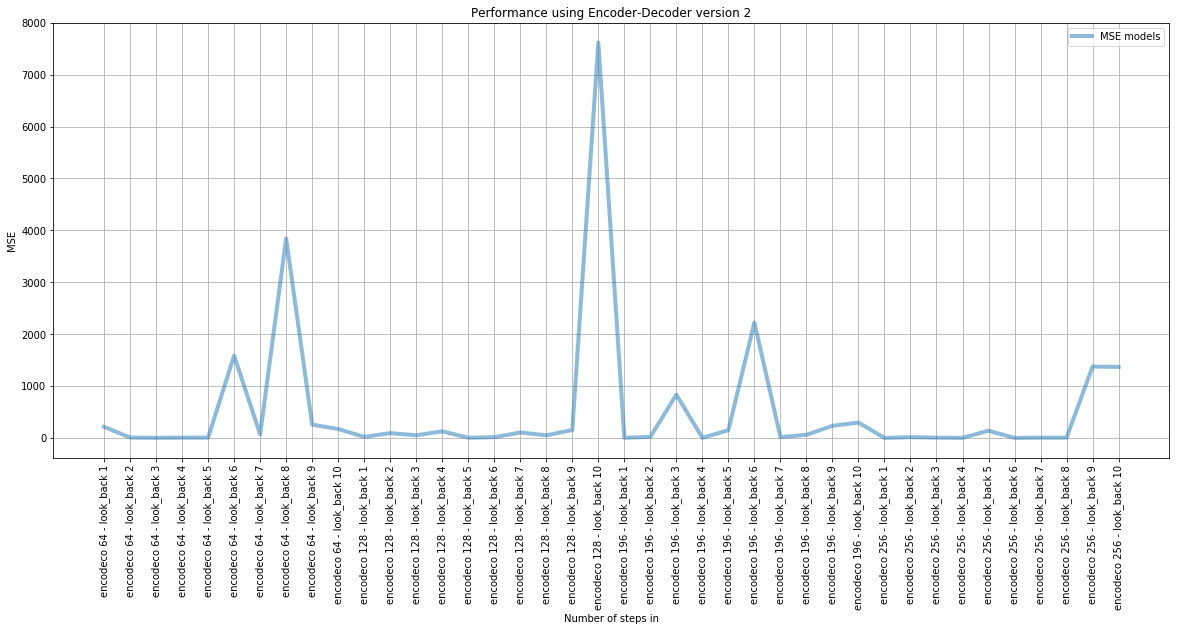

In [20]:
plot_metrics_model(encodeco_mse_2,encodeco_combinations_2, "Performance using Encoder-Decoder version 2")

Se muestra la pérdida mse de los modelos Encoder-Decoder version 2.

In [21]:
columns = ['model', 'mse']
df_models_encodeco_2 = pd.DataFrame(columns=columns)
df_models_encodeco_2['model'] = encodeco_combinations_2
df_models_encodeco_2['mse'] = encodeco_mse_2
df_models_encodeco_2

,model,mse
0,encodeco 64 - look_back 1,213.536317
1,encodeco 64 - look_back 2,7.177108
2,encodeco 64 - look_back 3,2.020138
3,encodeco 64 - look_back 4,5.592572
4,encodeco 64 - look_back 5,6.807046
5,encodeco 64 - look_back 6,1585.369845
6,encodeco 64 - look_back 7,68.750182
7,encodeco 64 - look_back 8,3843.852739
8,encodeco 64 - look_back 9,256.353716
9,encodeco 64 - look_back 10,171.534039


Elegimos el modelo Encoder-Decoder version 2 de menor pérdida mse.

In [22]:
index_model_min_mse = df_models_encodeco_2[df_models_encodeco_2.mse == df_models_encodeco_2.mse.min()].index[0]
look_back = df_models_encodeco_2.loc[index_model_min_mse,'model']
look_back = int(look_back[look_back.rfind(" ")+1:])
print index_model_min_mse, look_back
df_models_encodeco_2[df_models_encodeco_2.mse == df_models_encodeco_2.mse.min()]

30 1


,model,mse
30,encodeco 256 - look_back 1,0.122807


Realizamos las predicciones con el modelo Encoder-Decoder version 2 seleccionado.

In [24]:
model_encodeco_2 = encodeco_models_2[index_model_min_mse]
model_encodeco_2.summary()
trainPredict = model_encodeco_2.predict(X_train[look_back-1])
testPredict = model_encodeco_2.predict(X_test[look_back-1])
trainPredict.shape, testPredict.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 256)               294912    
_________________________________________________________________
repeat_vector_32 (RepeatVect (None, 1, 256)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 1, 128)            197120    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 1, 1)              129       
Total params: 492,161
Trainable params: 492,161
Non-trainable params: 0
_________________________________________________________________


((1833, 1, 1), (903, 1, 1))

In [25]:
Original_serie = scaler.fit_transform(data[:,2].reshape(-1, 1))
Original_serie.shape

(2738, 1)

In [26]:
x_lab1=[]
for i in range(Original_serie.shape[0]):
    x_lab1.append(i)
x_lab2=[]
for i in range(trainPredict.shape[0]):
    x_lab2.append(i)
x_lab3=[]
for i in range(trainPredict.shape[0]+3,Original_serie.shape[0]+1):
    x_lab3.append(i)
    
len(x_lab1), Original_serie.shape[0],len(x_lab2), trainPredict.shape[0],len(x_lab3), testPredict.shape[0]

(2738, 2738, 1833, 1833, 903, 903)

Se grafican las predicciones del modelo Encoder-Decoder version 2 con los datos de cierre de precio originales.

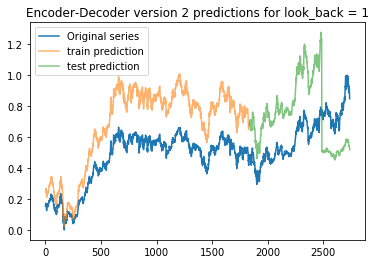

In [27]:
plot_predictions_model(x_lab1, 
                       Original_serie, 
                       x_lab2, 
                       np.reshape(trainPredict,(trainPredict.shape[0]*time_ahead)), 
                       x_lab3, 
                       np.reshape(testPredict,(testPredict.shape[0]*time_ahead)), 
                       "Encoder-Decoder version 2 predictions for look_back = 1")

Se observa que los resultados son similares a los obtenidos con el modelo Encoder-Decoder del punto 5.

Se exporta el modelo Encoder-Decoder version 2 entrenado.

In [32]:
model_dir = './models/'
tf.gfile.MakeDirs(model_dir)
model_name = df_models_encodeco_2.loc[index_model_min_mse,'model']
model_encodeco_2.save(model_dir+model_name+"_version2.model")